# Домашнее задание 2. StarGAN

## Этап 1. Установка зависимостей, инициализация и загрузка данных

В этом разделе мы работаем с датасетом CelebA, содержащим изображения лиц с набором атрибутов. Целью задания является генерация новых изображений лиц с заданными характеристиками.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%pip install lpips -q

import sys
sys.path.append('../')  # Добавляем путь к CelebADataset

import torch
from lpips import LPIPS
from torchvision import transforms
from munch import Munch
from tqdm.auto import trange
import matplotlib.pyplot as plt
import numpy as np
from seminars.utils.datasets.celeba import CelebADataset

device: str = 'cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu')
device = torch.device(device)


[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
args = Munch()
# args.img_size = 256  # Размер изображений после преобразования

# # Создание последовательности преобразований для подготовки изображений
args.img_size = 64  # or 96
# transform = transforms.Compose([
#     transforms.Resize(args.img_size),
#     transforms.CenterCrop(args.img_size),
#     transforms.ToTensor(),
#     transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5]),
# ])
transform=transforms.Compose([
    transforms.Resize(args.img_size),
    transforms.CenterCrop(args.img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
])

# Загрузка датасета CelebA с применением указанных преобразований
dataset = CelebADataset(
    root_dir='../seminars/data/celeba',
    transform=transform)

# Число потоков для загрузки данных
num_workers = 0 if device.type == 'cuda' else 2
# Whether to put fetched data tensors to pinned memory
pin_memory = True if device.type == 'cuda' else False

# args.batch_size = ...   # Задайте размер батча
args.batch_size = 32

# Создание DataLoader
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=args.batch_size,
    num_workers=num_workers,
    pin_memory=pin_memory,
    shuffle=True
)

In [4]:
args.num_domains = 2  # Задайте число доменов
# args.num_domains = len(dataset.header) 

### Визуализация датасета

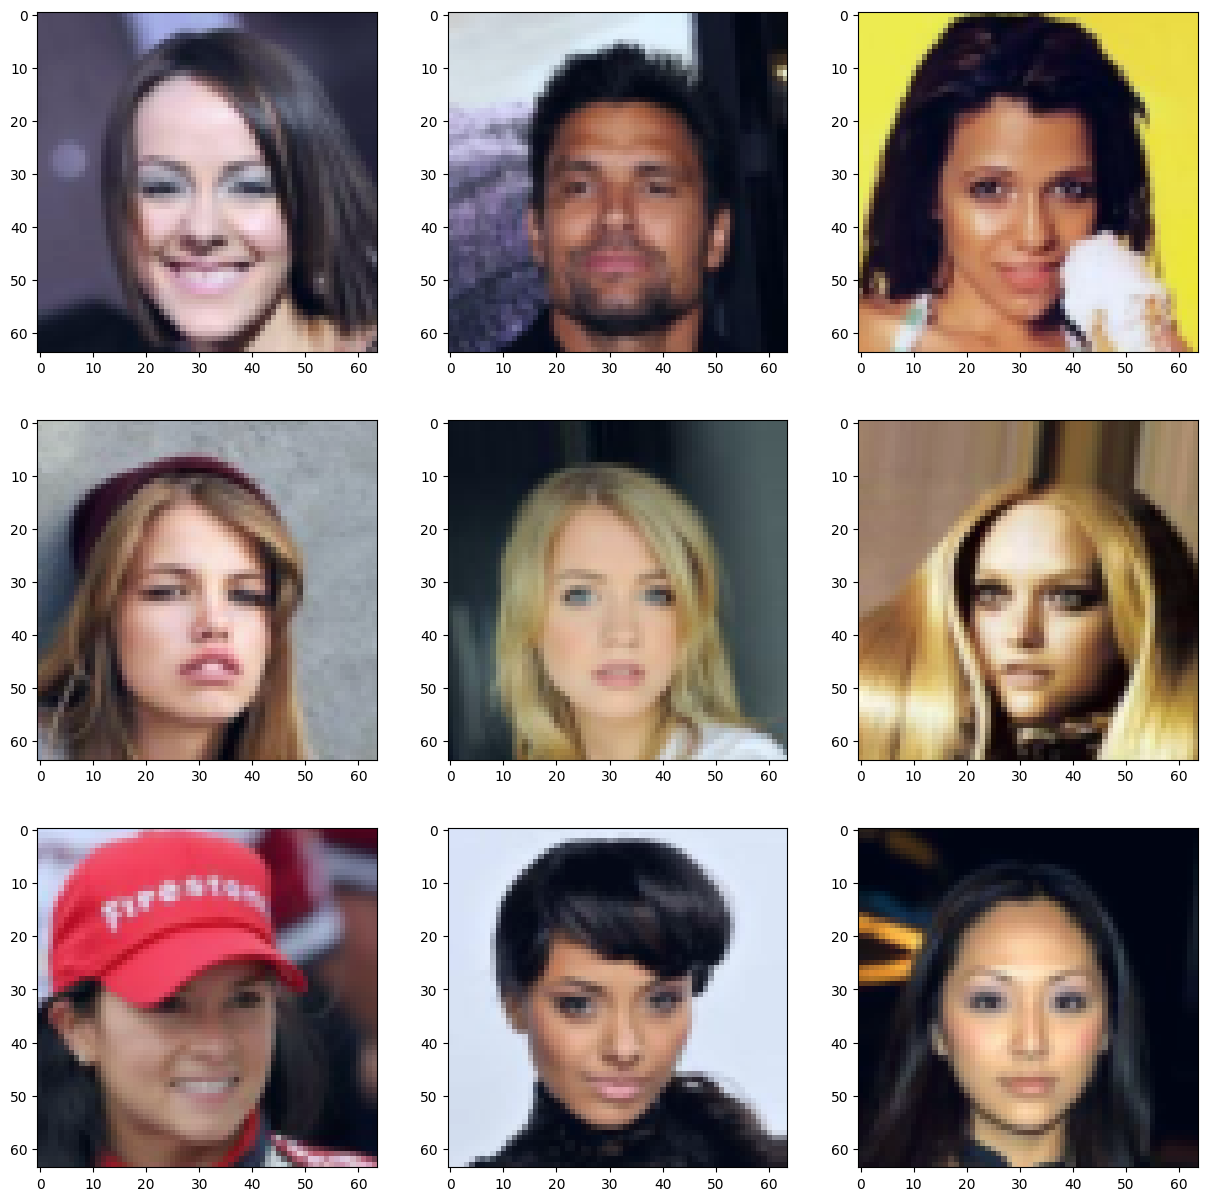

In [5]:
# Визуализация случайно выбранных изображений из датасета

_, axes = plt.subplots(ncols=3, nrows=3, figsize=(15, 15))
for i, img_idx in enumerate(np.random.choice(range(len(dataset)), 9)):

    img, target = dataset[img_idx]
    img = (img - img.min()) / (img.max() - img.min())
    axes[i // 3][i % 3].imshow(img.detach().cpu().numpy().transpose(1, 2, 0))

## Этап 2. Инициализация и обучение модели

В этом этапе необходимо реализовать и обучить модель StarGAN для генерации лиц с заданными атрибутами.

Вы можете выбрать одну из следующих моделей:
- [StarGANv1](https://arxiv.org/pdf/1711.09020.pdf) (**до 4 баллов**)
- [StarGANv2](https://arxiv.org/abs/1912.01865) (**до 7 баллов**)

### Инициализация

Ниже приведён шаблон для определения основных компонентов модели. Реализуйте их по своему усмотрению.

In [6]:
# Создание структуры для хранения компонентов модели
from HW2.model import Generator, StyleEncoder, MappingNetwork, Discriminator
from munch import Munch

num_domains = args.num_domains
style_dim = 64
latent_dim = 16

nets = Munch()
nets.generator = Generator(img_channels=3, dim=16, style_dim=style_dim)
nets.style_encoder = StyleEncoder(img_channels=3, dim=16, style_dim=style_dim, num_domains=num_domains)
nets.discriminator = Discriminator(img_channels=3, dim=16, num_domains=num_domains)
nets.mapping_network = MappingNetwork(latent_dim=latent_dim, hidden_dim=256, style_dim=style_dim, num_domains=num_domains)
# nets.generator = Generator(img_channels=3, dim=32, style_dim=style_dim)        # Генератор, отвечающий за преобразование изображений
# nets.mapping_network = MappingNetwork(latent_dim=latent_dim, hidden_dim=256, style_dim=style_dim, num_domains=num_domains)     # Сеть маппинга: преобразует латентный вектор в стиль
# nets.style_encoder = StyleEncoder(img_channels=3, dim=32, style_dim=style_dim, num_domains=num_domains)      # Энкодер стиля: извлекает стиль из изображений
# nets.discriminator = Discriminator(img_channels=3, dim=32, num_domains=num_domains)       # Дискриминатор: оценивает реалистичность сгенерированных изображений

In [7]:
import torch
import torch.nn.functional as F

def d_hinge_loss(logits_real, logits_fake):
    return torch.mean(F.relu(1.0 - logits_real)) + torch.mean(F.relu(1.0 + logits_fake))

def g_hinge_loss(logits_fake):
    return -torch.mean(logits_fake)

def get_domain_labels(info_dict, header, device):
    male_idx = header.index("Male")
    attrs = info_dict["attributes"].to(device)
    return (attrs[:, male_idx] > 0).long()

@torch.no_grad()
def flip_domain(y):
    return 1 - y

def train_step_cpu_light(nets, optims, batch, header, latent_dim, device):
    G, D, M, E = nets.generator, nets.discriminator, nets.mapping_network, nets.style_encoder
    x_real, info = batch
    x_real = x_real.to(device)
    y_org = get_domain_labels(info, header, device)
    y_trg = flip_domain(y_org)

    B = x_real.size(0)
    z = torch.randn(B, latent_dim, device=device)

    # ---- D ----
    optims.opt_d.zero_grad(set_to_none=True)
    out_real = D(x_real, y_org)

    with torch.no_grad():
        s_trg = M(z, y_trg)
        x_fake = G(x_real, s_trg)
    out_fake = D(x_fake.detach(), y_trg)

    loss_d = d_hinge_loss(out_real, out_fake)
    loss_d.backward()
    optims.opt_d.step()

    # ---- G (+M +E) ----
    optims.opt_g.zero_grad(set_to_none=True)
    optims.opt_m.zero_grad(set_to_none=True)
    optims.opt_e.zero_grad(set_to_none=True)

    s_trg = M(z, y_trg)
    x_fake = G(x_real, s_trg)
    out_fake = D(x_fake, y_trg)
    loss_adv = g_hinge_loss(out_fake)

    # style recon
    s_hat = E(x_fake, y_trg)
    loss_sty = F.l1_loss(s_hat, s_trg)

    # cycle (optional but useful)
    s_org = E(x_real, y_org)
    x_rec = G(x_fake, s_org)
    loss_cyc = F.l1_loss(x_rec, x_real)

    loss_g = loss_adv + 1.0 * loss_sty + 1.0 * loss_cyc
    loss_g.backward()

    optims.opt_g.step()
    optims.opt_m.step()
    optims.opt_e.step()

    return float(loss_d.detach().cpu()), float(loss_g.detach().cpu())

In [8]:
import os, torch

device = torch.device("cpu")  # force CPU
torch.set_num_threads(min(8, os.cpu_count() or 4))
torch.set_num_interop_threads(1)

In [9]:
from munch import Munch

lr = 1e-4
optims = Munch()
optims.opt_g = torch.optim.Adam(nets.generator.parameters(), lr=lr, betas=(0.0, 0.99))
optims.opt_d = torch.optim.Adam(nets.discriminator.parameters(), lr=lr, betas=(0.0, 0.99))
optims.opt_m = torch.optim.Adam(nets.mapping_network.parameters(), lr=lr, betas=(0.0, 0.99))
optims.opt_e = torch.optim.Adam(nets.style_encoder.parameters(), lr=lr, betas=(0.0, 0.99))

In [10]:
for k in nets.keys():
    nets[k].to(device)
    nets[k].train()

In [ ]:
# from torch.utils.data import Subset, DataLoader
# import numpy as np

# N = 10000
# idx = np.random.RandomState(0).choice(len(dataset), size=N, replace=False)
# dataset_small = Subset(dataset, idx)

# dataloader = DataLoader(dataset_small, batch_size=8, shuffle=True, num_workers=0)

# # IMPORTANT: header is inside the wrapped dataset
# header = dataloader.dataset.dataset.header

In [11]:
from tqdm import tqdm

latent_dim = 16  # must match MappingNetwork latent_dim

num_epochs = 1
log_every = 20
header = dataloader.dataset.header

global_step = 0
for epoch in range(num_epochs):
    pbar = tqdm(dataloader, desc=f"epoch {epoch+1}/{num_epochs}")
    for batch in pbar:
        loss_d, loss_g = train_step_cpu_light(
            nets=nets,
            optims=optims,
            batch=batch,
            header=header,
            latent_dim=latent_dim,
            device=device
        )
        global_step += 1

        if global_step % log_every == 0:
            pbar.set_postfix(loss_d=f"{loss_d:.3f}", loss_g=f"{loss_g:.3f}")

epoch 1/1:   0%|          | 25/6332 [01:38<5:12:41,  2.97s/it, loss_d=1.414, loss_g=1.401]libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipe
libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipe
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x130206480>
Traceback (most recent call last):
  File "/Users/naburkova/.pyenv/versions/3.11.8/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/Users/naburkova/.pyenv/versions/3.11.8/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1618, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Users/naburkova/.pyenv/versions/3.11.8/lib/python3.11/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/naburkova/.pyenv/versions/3.11.8/lib/python3.11/mu

KeyboardInterrupt: 

In [ ]:
torch.save({
    "generator": nets.generator.state_dict(),
    "style_encoder": nets.style_encoder.state_dict(),
    "mapping_network": nets.mapping_network.state_dict(),
    "discriminator": nets.discriminator.state_dict(),
}, "stargan_d2.pth")

----

In [7]:
optims = Munch()
optims.generator = torch.optim.Adam(
    list(nets.generator.parameters()) + list(nets.style_encoder.parameters()),
    lr=1e-4, betas=(0.0, 0.99)
)
optims.discriminator = torch.optim.Adam(
    nets.discriminator.parameters(),
    lr=1e-4, betas=(0.0, 0.99)
)

### Обучение

In [ ]:
# sm

### Оценка модели

Для оценки качества сгенерированных изображений используется метрика LPIPS.

In [9]:
import os
import random
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset


class CelebAMaleFemaleDataset(Dataset):
    """
    CelebA dataset for 2 domains: Female (0) vs Male (1),
    using Kaggle list_attr_celeba.csv.

    Expected:
      images_dir: .../img_align_celeba  (contains 000001.jpg ...)
      attr_csv:   .../list_attr_celeba.csv with columns: image_id, ..., Male, ...

    Returns:
      x: Tensor [3,H,W]
      y: LongTensor scalar in {0,1}
    """
    def __init__(self, images_dir: str, attr_csv: str, transform=None, keep_only_existing_images=True):
        self.images_dir = images_dir
        self.transform = transform

        df = pd.read_csv(attr_csv)
        if "image_id" not in df.columns or "Male" not in df.columns:
            raise ValueError("CSV must contain columns 'image_id' and 'Male'.")

        # Map Male: 1 -> 1 (male), -1 -> 0 (female)
        df["y"] = (df["Male"] == 1).astype(int)

        if keep_only_existing_images:
            # Keep only rows where the image file actually exists
            def exists_fn(fn):
                return os.path.isfile(os.path.join(images_dir, fn))
            mask = df["image_id"].apply(exists_fn)
            df = df.loc[mask].reset_index(drop=True)

        self.df = df
        self.filenames = df["image_id"].tolist()
        self.labels = df["y"].astype(int).tolist()

        # Precompute indices per domain for fast reference sampling
        self.indices_by_domain = {0: [], 1: []}
        for i, y in enumerate(self.labels):
            self.indices_by_domain[y].append(i)

        if len(self.indices_by_domain[0]) == 0 or len(self.indices_by_domain[1]) == 0:
            raise RuntimeError("One of the domains has 0 samples. Check your CSV/images_dir.")

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx: int):
        fn = self.filenames[idx]
        y = self.labels[idx]

        path = os.path.join(self.images_dir, fn)
        img = Image.open(path).convert("RGB")
        if self.transform is not None:
            img = self.transform(img)

        return img, torch.tensor(y, dtype=torch.long)

    def sample_ref(self, y_trg: int):
        """Sample one reference image index from target domain y_trg."""
        idx = random.choice(self.indices_by_domain[int(y_trg)])
        x_ref, _ = self[idx]
        return x_ref


In [10]:
from torch.utils.data import DataLoader

images_dir = "../seminars/data/celeba/img_align_celeba"  # adjust
attr_csv   = "../seminars/data/celeba/attributes/list_attr_celeba.csv"  # adjust

train_dataset = CelebAMaleFemaleDataset(images_dir, attr_csv, transform=transform)

use_mps = (torch.backends.mps.is_available() and device.type == "mps")
num_workers = 0  # <-- critical for notebook on macOS
pin_memory = False if use_mps else True

train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory,
    drop_last=True
)


In [12]:
from tqdm.auto import trange

nets.generator.train()
nets.style_encoder.train()
nets.discriminator.train()

steps = 50  # start small
loader_iter = iter(train_loader)

for step in trange(steps):
    try:
        batch = next(loader_iter)
    except StopIteration:
        loader_iter = iter(train_loader)
        batch = next(loader_iter)
    # for k, net in nets.items():
    #     net.to(device)
    #     net.train()
    logs = train_step_refguided(
        nets=nets,
        optims=optims,
        batch=batch,
        dataset=train_dataset,
        device=device,
        lambda_sty=1.0,
        lambda_cyc=0.0
    )

    if (step + 1) % 100 == 0:
        print(step + 1, logs)


  0%|          | 0/50 [00:00<?, ?it/s]

In [13]:
lpips = LPIPS()

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/Users/naburkova/.pyenv/versions/3.11.8/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/naburkova/.pyenv/versions/3.11.8/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /Users/naburkova/.pyenv/versions/3.11.8/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


In [16]:
torch.save({
    "generator": nets.generator.state_dict(),
    "style_encoder": nets.style_encoder.state_dict(),
    "mapping_network": nets.mapping_network.state_dict(),
    "discriminator": nets.discriminator.state_dict(),
}, "stargan_v2_checkpoint.pth")

In [ ]:
nets = Munch()
nets.generator = Generator(dim=32, style_dim=64)
nets.style_encoder = StyleEncoder(dim=32, style_dim=64, num_domains=2)
nets.mapping_network = MappingNetwork(latent_dim=16, style_dim=64, num_domains=2)
nets.discriminator = Discriminator(dim=32, num_domains=2)

checkpoint = torch.load("stargan_v2_checkpoint.pth", map_location=device)

In [43]:
test_iters = 2000  # Количество итераций для тестирования модели
values = []
args.num_domains=10

for i in trange(test_iters):
    x_real, _ = next(iter(dataloader))
    x_ref, _ = next(iter(dataloader))
    x_ref2, _ = next(iter(dataloader))
    
    batch_size = x_real.shape[0]
    
    # Случайное задание целевого и исходного доменов для каждого изображения
    y_trg = torch.tensor(np.random.choice(np.arange(args.num_domains), size=batch_size))  # Целевой домен
    y_org = torch.tensor(np.random.choice(np.arange(args.num_domains), size=batch_size))  # Исходный домен
    
    # Перенос данных на выбранное устройство и приведение типов
    x_real, x_ref, x_ref2 = [x.to(device).float() for x in [x_real, x_ref, x_ref2]]
    y_trg, y_org = [x.to(device).long() for x in [y_trg, y_org]]
    
    # Генерация изображения с использованием вашей модели
    with torch.no_grad():
        s_trg = nets.style_encoder(x_ref, y_trg)
        x_fake = nets.generator(x_real, s_trg)
    
    # Вычисление LPIPS между сгенерированным и реальным изображением
    values.append(lpips(x_fake, x_real).mean().item())

print("Среднее значение LPIPS:", np.mean(values))
assert np.mean(values) < 1.3

  0%|          | 0/2000 [00:00<?, ?it/s]

Среднее значение LPIPS: 0.6629277551472187


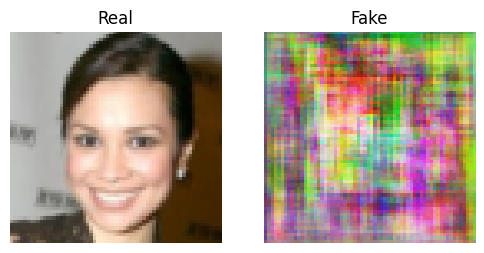

In [44]:
import random
import matplotlib.pyplot as plt

def denormalize(x):
    return (x * 0.5 + 0.5).clamp(0, 1)

def show_translation(nets, dataset, device):
    nets.generator.eval()
    nets.style_encoder.eval()

    idx = random.randint(0, len(dataset)-1)
    x_real, info = dataset[idx]

    header = dataset.header
    male_idx = header.index("Male")
    y_org = (info["attributes"][male_idx] > 0).long()
    y_trg = 1 - y_org

    x_real = x_real.unsqueeze(0).to(device)
    y_trg = torch.tensor([y_trg], device=device)

    # Use latent style for simplicity
    z = torch.randn(1, 16, device=device)
    with torch.no_grad():
        s_trg = nets.mapping_network(z, y_trg)
        x_fake = nets.generator(x_real, s_trg)

    x_real = denormalize(x_real[0].cpu())
    x_fake = denormalize(x_fake[0].cpu())

    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plt.title("Real")
    plt.imshow(x_real.permute(1,2,0))
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.title("Fake")
    plt.imshow(x_fake.permute(1,2,0))
    plt.axis("off")

    plt.show()

show_translation(nets, dataset, device)

### Вывод результатов оценки

In [20]:
with torch.no_grad():
    z_trg = torch.randn((batch_size, args.latent_dim)).to(device)
    s_trg = nets.mapping_network(z_trg, y_trg)
    # s_trg = nets.style_encoder(x_ref2, y_trg) 
    x_fake = nets.generator(x_real, s_trg)

plt.figure(figsize=(6, 6))
plt.imshow(x_fake[1].permute(1, 2, 0).detach().cpu().numpy())
plt.title("Сгенерированное изображение")
plt.axis('off')
plt.show()

AttributeError: latent_dim

## Этап 3. Дополнительный анализ

В данном разделе рекомендуется провести дополнительные эксперименты и анализ:
- **Анализ латентного пространства**. *(2 балла)*
- **Текстовое ревью решения**: опишите, какие изменения можно внести для улучшения модели, и обоснуйте их. *(1 балл)*